<a href="https://colab.research.google.com/github/enriquemx1/Forecasts/blob/main/arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import logging
import pickle
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    TimeSeriesSplit,
    GridSearchCV
)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import(
    plot_acf,
    plot_pacf
)
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
logger = logging.getLogger()
logger.setLevel(logging.ERROR)


In [ ]:
# Cargar Dataset
df_raw = pd.read_csv("/content/sample_data/HISTORY.csv")
# Ver la información general del dataset
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3720 entries, 0 to 3719
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SKILL   3720 non-null   object
 1   Date    3720 non-null   object
 2   CALLS   3720 non-null   int64 
 3   AHT     3720 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 116.4+ KB


In [ ]:
df_raw.columns = df_raw.columns.str.lower()
df_raw.sample(10,random_state=2025)

,skill,date,calls,aht
1717,ACD2_CPY_CS_AM_EN482,16/01/2021,124,178
756,ACD2_B_P_T2_AM_EN434,13/06/2020,8,206
1074,ACD2_B_P_T2_AM_EN434,27/04/2021,23,153
0,ACD2_AGT_AS_AM_EN173,01/06/2020,2831,230
2748,ACD2_TMT_CS_AM_EN405,23/10/2020,2575,306
3347,DVSA_B_P_CS_AM_ES218,07/06/2021,46,284
1844,ACD2_CPY_CS_AM_EN482,23/05/2021,25,170
3173,DVSA_B_P_CS_AM_ES218,15/12/2020,49,301
461,ACD2_B_P_CS_AM_EN419,29/08/2020,327,238
3179,DVSA_B_P_CS_AM_ES218,21/12/2020,46,227


In [ ]:
# Convertir la columna 'date' a formato datetime especificando el formato
# Esto es porque mi fecha viene en formato dd/mm/yyyy
df_raw['date'] = pd.to_datetime(df_raw['date'], dayfirst=True)

# Verificar el cambio
df_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3720 entries, 0 to 3719
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   skill   3720 non-null   object        
 1   date    3720 non-null   datetime64[ns]
 2   calls   3720 non-null   int64         
 3   aht     3720 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 116.4+ KB


In [ ]:
# Si hubiera venido una col con mes y una col con año debería hacer:
    #vamos a convertir  el contenido de month a formato de mes
    # df_baking = df_raw.copy()
    # df_baking['month'] = pd.to_datetime(df_baking['mont'], format="%b").dt.month
    # .dt extrae cualquier valor que sea fecha, en este caso mes
# Luego concatenamos el año
    #creamos una col llamada date
    #le metemos 'year' y 'month'
    #como no tenemos day le forzamos el 1 con .assign(day=1)
    # df_baking['date'] = pd.to_datetime(df_baking[['year','month']].assign(day=1))
# Volvemos la fecha como indice
    #df_baking = df_baking.set_index('date')

In [ ]:
# Hay que volver la fecha index
df_baking = df_raw.copy()
df_baking = df_baking.set_index('date')
df_baking.sample(5, random_state=2025)

# Identificar si hay más de un nombre de skill
unique_skills = df_baking['skill'].unique()

# Verificar si hay más de un skill único
if len(unique_skills) > 1:
    print(f"Se encontraron múltiples skills: {unique_skills}")
    # Preguntar al usuario cuál conservar
    skill_to_keep = input("¿Cuál skill deseas conservar? (Escribe el nombre exacto): ")

    # Filtrar para conservar solo el skill seleccionado
    if skill_to_keep in unique_skills:
        df_baking = df_baking[df_baking['skill'] == skill_to_keep]
        print(f"Filtrado completado. Solo se conserva el skill '{skill_to_keep}'.")
    else:
        print("El skill proporcionado no es válido. No se realizaron cambios.")
else:
    print(f"Solo se encontró un skill: {unique_skills[0]}. No se necesita filtrar.")


Se encontraron múltiples skills: ['ACD2_AGT_AS_AM_EN173' 'ACD2_B_P_CS_AM_EN419' 'ACD2_B_P_T2_AM_EN434'
 'ACD2_COM_TS_AM_EN415' 'ACD2_CPY_CS_AM_EN482' 'ACD2_GCF_CS_AM_EN408'
 'ACD2_MTB_RC_AM_EN229' 'ACD2_TMT_CS_AM_EN405' 'DVSA_B_P_CS_AM_ES218'
 'DVSA_CPY_CS_AM_ES283']
¿Cuál skill deseas conservar? (Escribe el nombre exacto): ACD2_MTB_RC_AM_EN229
Filtrado completado. Solo se conserva el skill 'ACD2_MTB_RC_AM_EN229'.


In [ ]:
# Comprobar skills unicos
print("Valores únicos en la columna 'skill':", df_baking['skill'].unique())

Valores únicos en la columna 'skill': ['ACD2_MTB_RC_AM_EN229']


In [ ]:
df = df_baking.copy()

# Definir índices para dividir los datos
train_size = int(0.8 * len(df))  # 70% de los datos para entrenamiento

# Crear los DataFrames de entrenamiento y prueba
df_train = df.iloc[:train_size, :]  # Desde el inicio hasta el 70% del dataset
df_test = df.iloc[train_size:, :]   # Desde el 70% hasta el final del dataset

# Verificar la división
print(f"Datos de entrenamiento: {len(df_train)} filas")
print(f"Datos de prueba: {len(df_test)} filas")
df_train.info()

Datos de entrenamiento: 297 filas
Datos de prueba: 75 filas
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 297 entries, 2020-06-01 to 2021-03-24
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   skill   297 non-null    object
 1   calls   297 non-null    int64 
 2   aht     297 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 9.3+ KB


In [ ]:
# Generar estadísticas descriptivas por 'skill'
df_train.describe().T.round(0)


,count,mean,std,min,25%,50%,75%,max
calls,297.0,2432.0,570.0,1152.0,1987.0,2290.0,2909.0,3753.0
aht,297.0,283.0,25.0,232.0,264.0,277.0,300.0,365.0


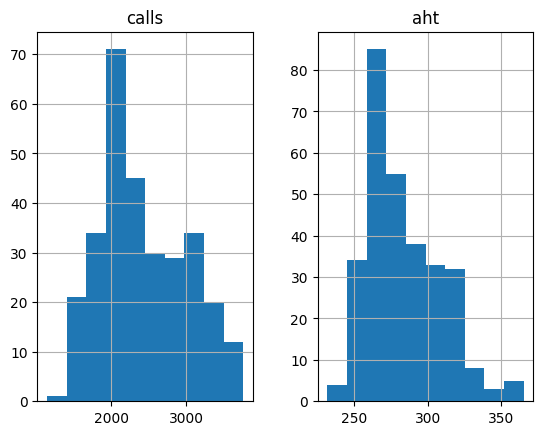

In [ ]:
# Crear un histograma para 'calls' agrupado por 'skill'
df_train.hist()
plt.show()

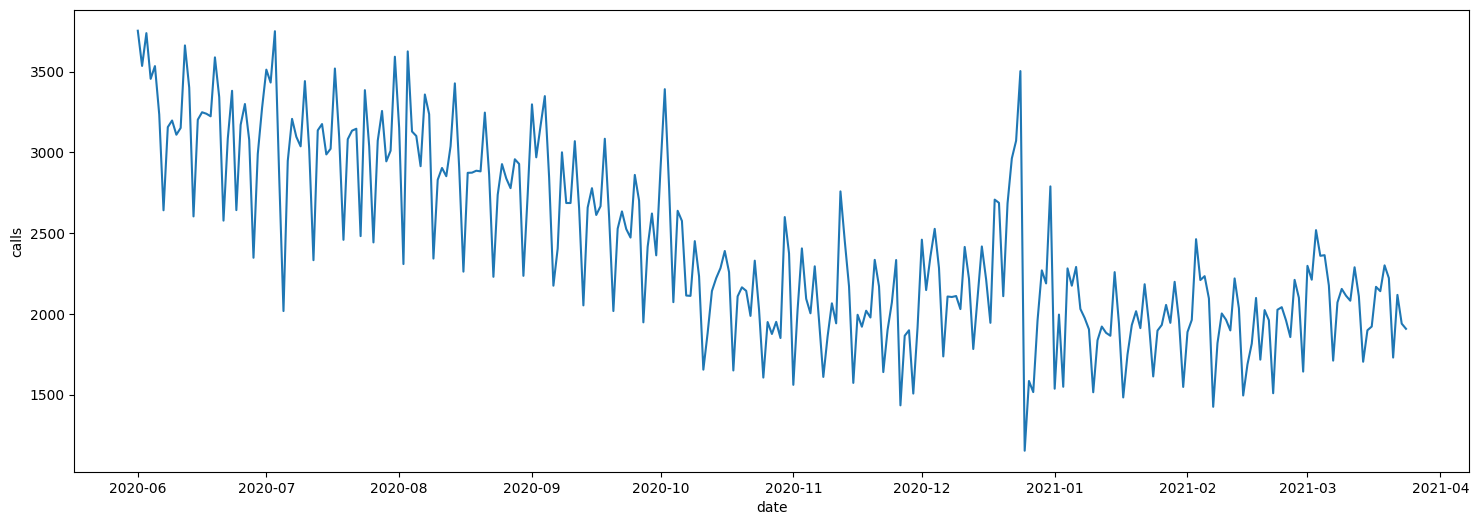

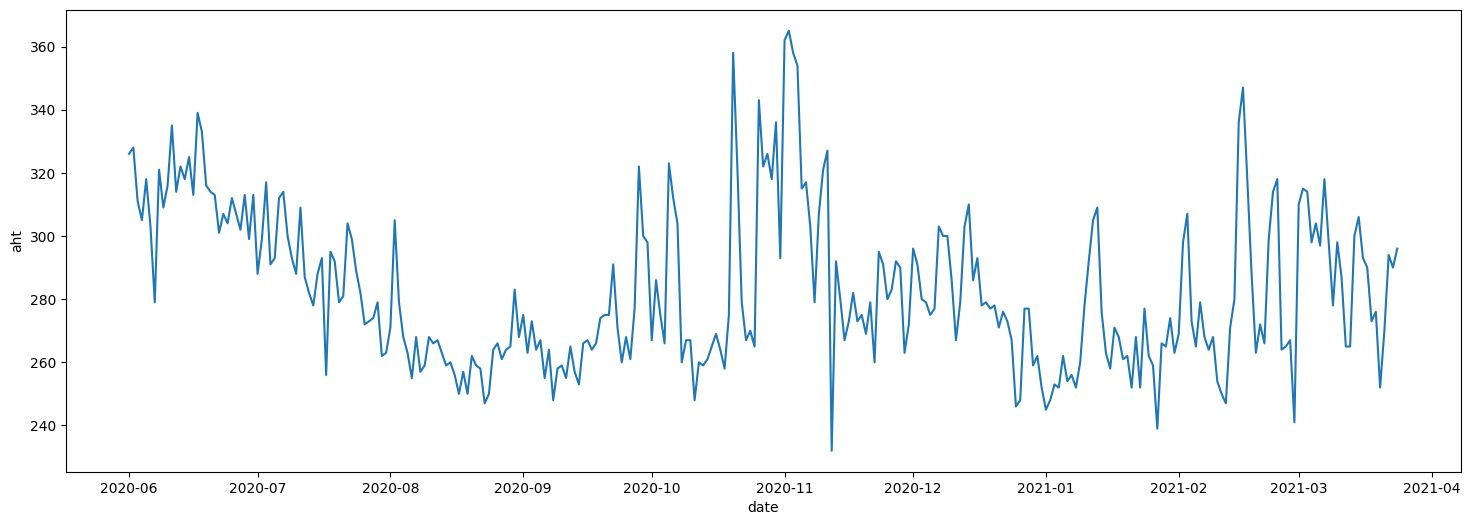

In [ ]:
# Lista de skills
plt.figure(figsize=(18, 6))
sns.lineplot(df_train['calls'])
plt.show()
plt.figure(figsize=(18, 6))
sns.lineplot(df_train['aht'])
plt.show()

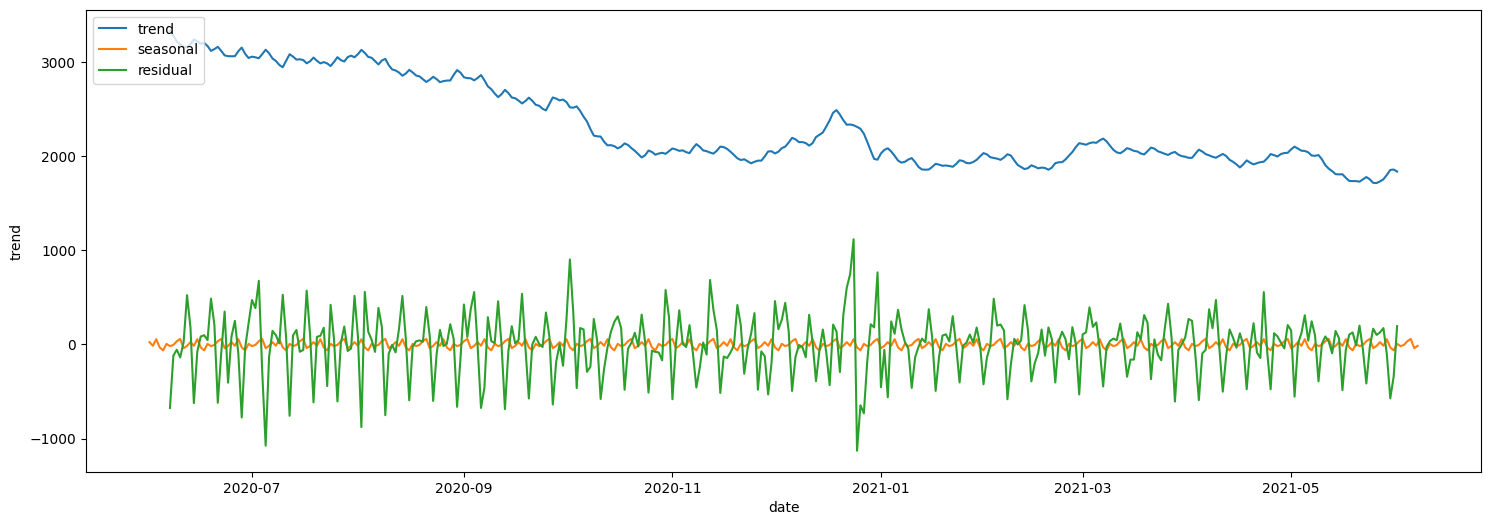

In [ ]:
# Descomposición estacional del tiempo
plt.figure(figsize=(18, 6))
decomposition = seasonal_decompose(df['calls'], period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
sns.lineplot(trend, label= 'trend')
sns.lineplot(seasonal, label= 'seasonal')
sns.lineplot(residual, label= 'residual')
plt.legend(loc='upper left')
plt.show()


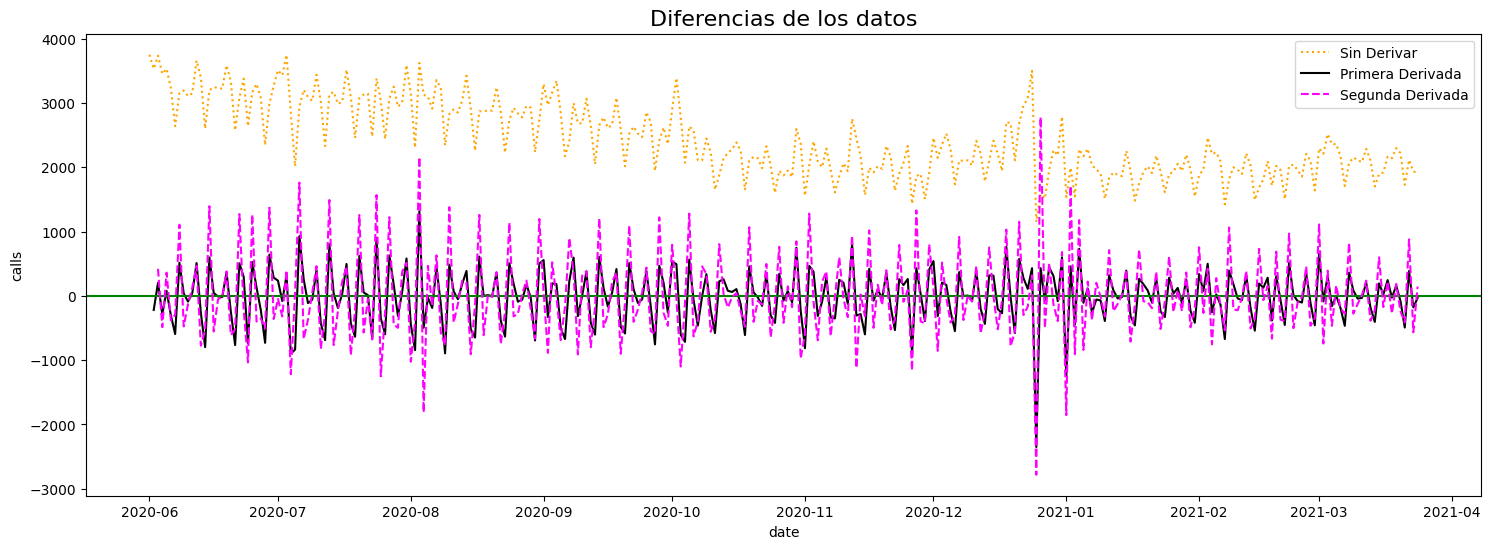

In [ ]:
plt.figure(figsize=(18, 6))
# Generar el orden de derivada para volver estacionarios los datos (estacionario = los datos no tienen tendencia)

# Debemos quitar el ruido para que los datos oscilen de manera horizontal

# Sin derivadar
sns.lineplot(df_train['calls'], color='orange', linestyle=':', label='Sin Derivar')

# Primera derivada
sns.lineplot(df_train['calls'].diff(), color='black', label='Primera Derivada')

# Línea base
plt.axhline(0, color='green')

# Segunda Derivada
sns.lineplot(df_train['calls'].diff().diff(), color='magenta', linestyle='--', label='Segunda Derivada')

# Título
plt.title('Diferencias de los datos', fontsize=16)
plt.legend()
plt.show()




In [ ]:
# d
# Prueba de datos estacionarios

# Inicializar la variable d
d = 0  # Número de derivadas realizadas para estacionarizar

# Prueba ADF sin diferenciación
ad_fuller = adfuller(df_train['calls'])
print(f"Estadístico ADF (sin diferenciar): {ad_fuller[0]:.2f}")
print(f"p-value: {ad_fuller[1]:.2f}")

# Verificar si el p-value es mayor a 0.05
if ad_fuller[1] > 0.05:
    print("El p-value es alto, los datos no son estacionarios. Aplicando primera diferencia...")
    d += 1  # Incrementamos d a 1 (primera diferencia)

    # Prueba ADF con primera diferencia
    ad_fuller_diff = adfuller(df_train['calls'].diff().dropna())
    print(f"Estadístico ADF (primera diferencia): {ad_fuller_diff[0]:.5f}")
    print(f"p-value (primera diferencia): {ad_fuller_diff[1]:.5f}")

    # Verificar si el p-value sigue siendo alto
    if ad_fuller_diff[1] > 0.05:
        print("El p-value sigue siendo alto, los datos aún no son estacionarios. Aplicando segunda diferencia...")
        d += 1  # Incrementamos d a 2 (segunda diferencia)

        # Prueba ADF con segunda diferencia
        ad_fuller_diff2 = adfuller(df_train['calls'].diff().diff().dropna())
        print(f"Estadístico ADF (segunda diferencia): {ad_fuller_diff2[0]:.5f}")
        print(f"p-value (segunda diferencia): {ad_fuller_diff2[1]:.5f}")

        if ad_fuller_diff2[1] > 0.05:
            print("El p-value sigue siendo alto incluso tras la segunda diferencia.")
        else:
            print("La segunda diferencia logró estacionarizar los datos.")
    else:
        print("La primera diferencia logró estacionarizar los datos.")
else:
    print("El p-value es bajo, los datos son estacionarios. No se requiere diferenciación.")

# Mostrar el valor final de d
print(f"El número final (d) de diferencias necesarias para estacionarizar los datos es: {d}")


Estadístico ADF (sin diferenciar): -1.56
p-value: 0.50
El p-value es alto, los datos no son estacionarios. Aplicando primera diferencia...
Estadístico ADF (primera diferencia): -6.27558
p-value (primera diferencia): 0.00000
La primera diferencia logró estacionarizar los datos.
El número final (d) de diferencias necesarias para estacionarizar los datos es: 1


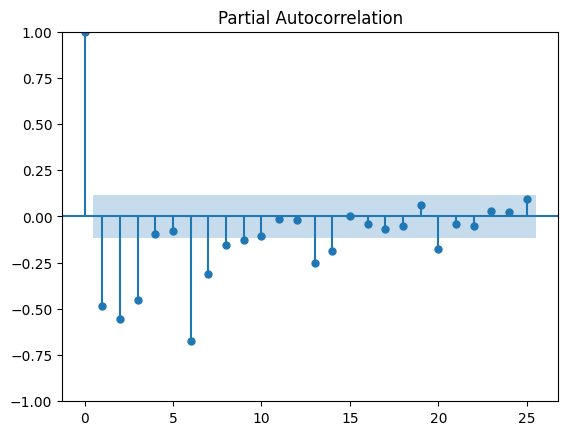

In [ ]:
# p
# Término autoregresivo
plot_pacf(df_train['calls'].diff().diff().dropna())
plt.show()
# el valor de p se determina contando los puntos que caen afuera de la banda
# descartamos el primero, y contamos los siguientes
# porque la correlación entre si mismo es 1
# cada punto es el resultado de su relación con el punto anterior

In [ ]:
# Cuántos puntos están fuera de las bandas de confianza
try:
    p = int(input("Por favor, cuenta los puntos fuera de las bandas de confianza en el gráfico PACF e ingrésalo: "))
    print(f"El valor de 'p' se ha establecido en: {p}")
except ValueError:
    print("El valor ingresado no es un número válido. Por favor, intenta nuevamente.")


Por favor, cuenta los puntos fuera de las bandas de confianza en el gráfico PACF e ingrésalo: 3
El valor de 'p' se ha establecido en: 3


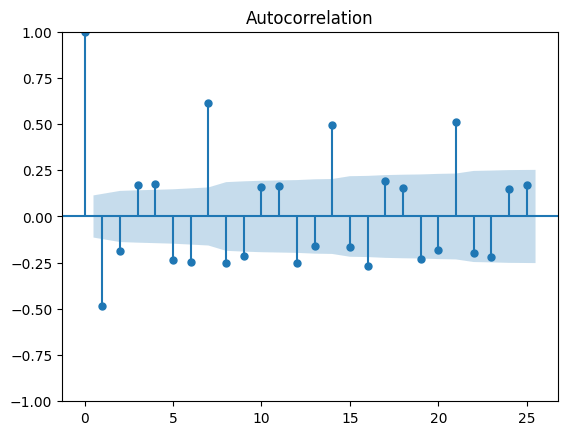

In [ ]:
# q
# promedio movil
plot_acf(df_train['calls'].diff().diff().dropna())
plt.show()
# el valor de q se determina contando los puntos que caen afuera de la banda
# descartamos el primero, y contamos los siguientes
# porque la correlación entre si mismo es 1
# cada punto es el resultado de su relación con el punto anterior
# dejamos de contar en cuanto entre uno a la banda celeste

In [ ]:
# Cuántos puntos están fuera de las bandas de confianza
try:
    q = int(input("Por favor, cuenta los puntos fuera de las bandas de confianza en el gráfico ACF e ingrésalo: "))
    print(f"El valor de 'q' se ha establecido en: {q}")
except ValueError:
    print("El valor ingresado no es un número válido. Por favor, intenta nuevamente.")

Por favor, cuenta los puntos fuera de las bandas de confianza en el gráfico ACF e ingrésalo: 9
El valor de 'q' se ha establecido en: 9


In [ ]:
# machine learning
print(f"'d' (diferencial)             = {d}")
print(f"'p' (partial autocorrelation) = {p}")
print(f"'q' (moving average)          = {q}")

arima = ARIMA(df_train['calls'], order=(d,p,q))
ts_arima = arima.fit()

print(ts_arima.summary())

# P>|z| debe ser cercano a 0
# AIC (aicake number) entre más pequeño mejor pues hay menos pérdida de datos
# A veces se puede achicar el P value y no el AIC, es uno o el otro

'd' (diferencial)             = 1
'p' (partial autocorrelation) = 3
'q' (moving average)          = 9


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  calls   No. Observations:                  297
Model:                 ARIMA(1, 3, 9)   Log Likelihood               -2216.937
Date:                Thu, 13 Mar 2025   AIC                           4455.873
Time:                        08:04:14   BIC                           4496.393
Sample:                    06-01-2020   HQIC                          4472.100
                         - 03-24-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2531      0.375     -0.674      0.500      -0.989       0.482
ma.L1         -2.2622    625.012     -0.004      0.997   -1227.264    1222.739
ma.L2          1.1804   1414.011      0.001      0.9

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
y_hat = ts_arima.predict(start=df_train.index[0], end=df.index[-1])
print(y_hat)

2020-06-01       0.000000
2020-06-02    8384.513535
2020-06-03    4023.862710
2020-06-04    4199.264828
2020-06-05    2919.354094
                 ...     
2021-06-03    2266.179284
2021-06-04    2272.662601
2021-06-05    2279.227096
2021-06-06    2285.872768
2021-06-07    2292.599618
Freq: D, Name: predicted_mean, Length: 372, dtype: float64


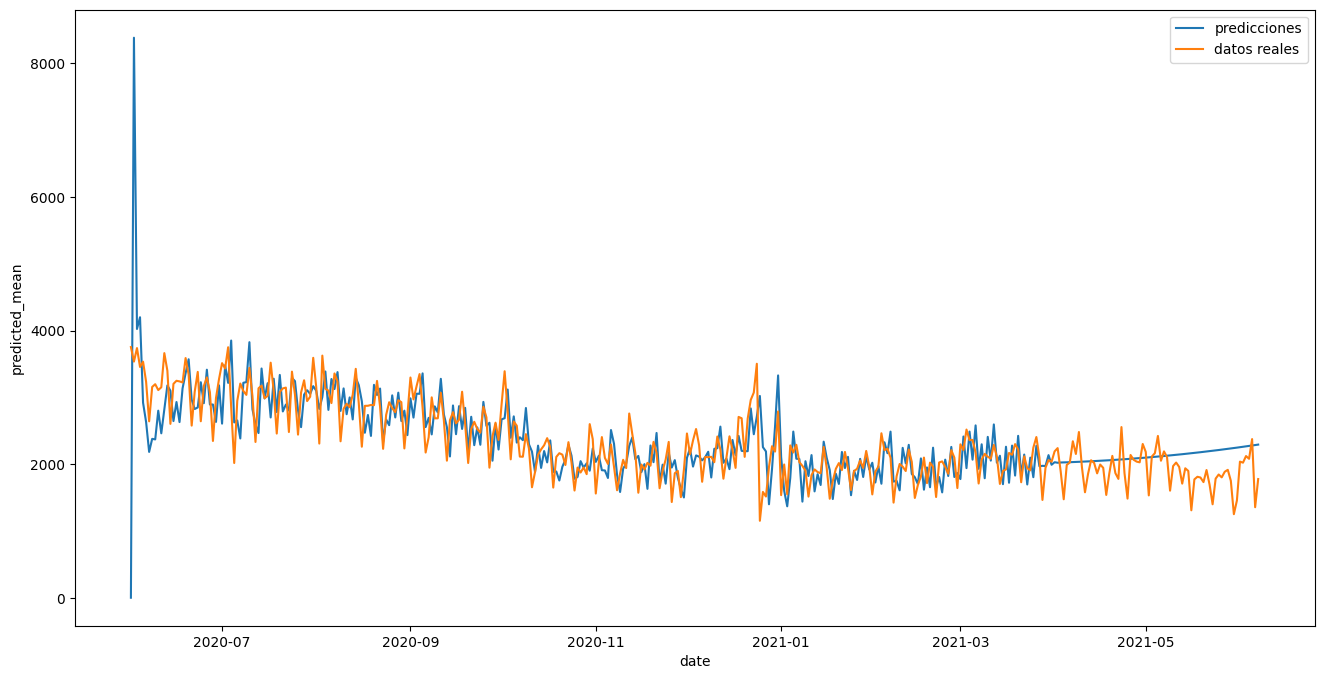

In [ ]:
plt.figure(figsize=(16, 8))
sns.lineplot(y_hat, label='predicciones')
sns.lineplot(df['calls'], label='datos reales')
plt.legend()
plt.show()


In [ ]:
print(df_baking.index.min())
print(df_baking.index.max())
print(df_train.index.min())
print(df_train.index.max())

2020-06-01 00:00:00
2021-06-07 00:00:00
2020-06-01 00:00:00
2021-02-15 00:00:00
